# Introduction to Coba
Coba is a Python package built to study the performance of contextual bandit (CB) learners via emperical experimentation. The CB problem considers how a computational agent can learn to make better choices over time. This means that in the field of CB research scientist study long sequences of situations in which a decision must be made. Each time a decision is made the effect of that decision is observed as some form of feedback. It is the job of CB algorithms then to integrate this feedback, along with knowledge of the situation in which the decision was made, in order to improve future decisions.

In order to create a research tool for the above problem that is both general and accessible Coba has been organized around four core concepts:
1. **Environments**: These are the sequences of situations in which decisions must be made. Individual environments should be semantically consistent.
2. **Learners**: These are the contextual bandit algorithms that Coba was built to study. Learners are able to make decisions and learn from feedback
3. **Experiments**: This is the emprical process where we determine how well selected *learners* perform in various *environments* of interest.
4. **Results**: This is the outcome of an experiment. It contains all the data necessary to analyze what happened and how well the learners performed.

The general Coba workflow is: 1) create or select the environments to use for evaluation, 2) select the CB learners to evaluate,  3) create an experiment using the selected learners and environments, and 4) run the experiment and analyze the results. In what follows we will walk you through this workflow below and show you how to use the many learners and environments provided by Coba out of the box. 


## Your First Coba Experiment
### Selecting Environments
Every experiment in Coba begins by selecting which environments to use for learner evaluation. Coba provides a high level interface called **Environments** to create easily create and modify environments. Using this interface we are going to create a basic linear environment built primarily to debug CB learners. We're also going to apply a small transform to it **Binary**. This will transform our environment so that the action with the highest reward has a feedback value of 1 while all other actions have a fedback of 0 in each interaction. This will be useful for interpretation later on.

In [1]:
import coba as cb

environments = cb.Environments.from_linear_synthetic(500).binary()

### Selecting Learners
Next an experiment needs some learners to evaluate. Coba comes with a number of existing learners. We're going to pick three:
1. **RandomLearner**: This learner randomly selects actions. It is useful as a comparison to make sure learners are actually "learning".
2. **EpsilonBanditLearner**: This learner follows an epsilon greedy policy when selecting actions and ignores context features.
3. **VowpalEpsilonLearner**: This learner is a wrapper around the Vowpal Wabbit ML package that implements several contextual bandit algorithms.

### Running the Experiment
Now that we've selected our environments and learners we are ready to run our experiment. Experiments in Coba are orchestrated by the Experiment class. This class takes care of all the hard work of actually evaluating our learners against our environments. Creating and running our first experiment looks like this:

2022-11-18 10:21:11 -- Processing chunk...
2022-11-18 10:21:11 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-11-18 10:21:11 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-11-18 10:21:11 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-11-18 10:21:11 --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.35 seconds) (completed)
2022-11-18 10:21:11 --   * Creating Environment 0 from Loaded Source... (0.01 seconds) (completed)
2022-11-18 10:21:11 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-11-18 10:21:11 --   * Evaluating Learner 0 on Environment 0... (0.54 seconds) (completed)
2022-11-18 10:21:11 --   * Evaluating Learner 1 on Environment 0... (0.03 seconds) (completed)
2022-11-18 10:21:12 --   * Evaluating Learner 2 on Environment 0... (0.03 seconds) (completed)


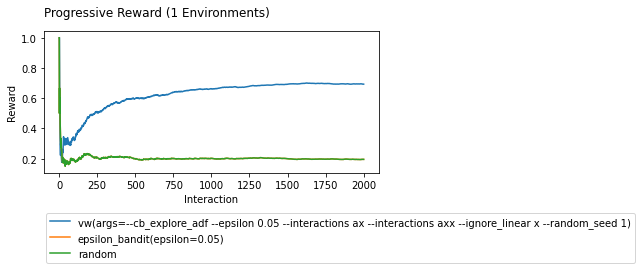

In [13]:
import coba as cb

environments = cb.Environments.from_linear_synthetic(2000).binary()
learners     = [ cb.VowpalEpsilonLearner(), cb.EpsilonBanditLearner(), cb.RandomLearner()]

cb.Experiment(environments, learners).run().plot_learners()

And just like that we've run our first experiment in Coba. 

Taking a quick moment to explain the plot, the X-axis indicates how many times our learners have interacted with the simulation while the Y-axis indicates the average reward received since the beginning of the Experiment. The legend below the plot shows each learner and their hyperparameters. 

Of course, running a single experiment often leads to more questions. Where is the **EpsilonBanditLearner**? In this case it is immediately beneath **RandomLearner**. There are a few reasons for why this happened so let's see if we can't figure this out by running a second experiment.

## Your Second Coba Experiment
As we mentioned above bandit learners don't consider context or action features when choosing actions. For our second experiment then we're going to modify the **LinearSyntheticSimulation** to see what parameters are causing this strange behavior. Look at the new code and notice the new parameter `n_action_features=0`.

2022-11-18 10:21:05 -- Processing chunk...
2022-11-18 10:21:05 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-11-18 10:21:05 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-11-18 10:21:05 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-11-18 10:21:05 --   * Loading LinearSynth(A=5,c=5,a=0,R=['a', 'xa'],seed=1)... (0.3 seconds) (completed)
2022-11-18 10:21:05 --   * Creating Environment 0 from Loaded Source... (0.02 seconds) (completed)
2022-11-18 10:21:05 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-11-18 10:21:06 --   * Evaluating Learner 0 on Environment 0... (0.51 seconds) (completed)
2022-11-18 10:21:06 --   * Evaluating Learner 1 on Environment 0... (0.05 seconds) (completed)
2022-11-18 10:21:06 --   * Evaluating Learner 2 on Environment 0... (0.0 seconds) (completed)


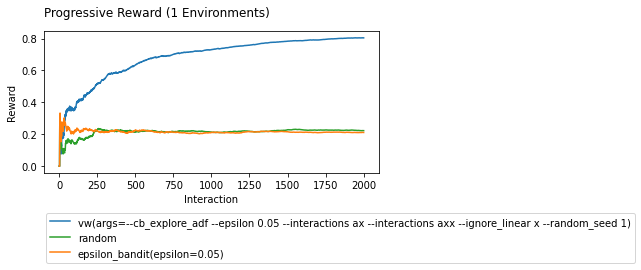

In [12]:
import coba as cb

environments = cb.Environments.from_linear_synthetic(2000,n_action_features=0).binary()
learners     = [ cb.VowpalEpsilonLearner(), cb.EpsilonBanditLearner(), cb.RandomLearner()]

cb.Experiment(environments, learners).run().plot_learners()

Look at that! **EpsilonBanditLearner** and **RandomLearner** are no longer identical. So what happened? 

When we set `n_action_features=0` this changed the **LinearSyntheticSimulation** so that its actions no longer had "features". To understand what this means it helps to consider an example where we want to recommended a movie. Our actions in this case would be movies and each movie may have certain features that helps us decide what to recommend like its genre or critic rating. When our actions don't have features the environment is more like recommending an activity such as reading, watching a movie or going for a walk than a movie. That is, each action is distinguishable without needing features to describe it. Why do you think this changed the performance of **EpsilonBanditLearner**?

Ok, time for one final experiment. Let's see if we can get **EpsilonBanditLearner** performing competitively.

## One Final Experiment
For this final experiment we're going to make several changes to the **LinearSyntheticSimulation**.

2022-11-18 10:22:38 -- Processing chunk...
2022-11-18 10:22:38 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-11-18 10:22:38 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-11-18 10:22:38 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2022-11-18 10:22:38 --   * Loading LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1)... (0.02 seconds) (completed)
2022-11-18 10:22:38 --   * Creating Environment 0 from Loaded Source... (0.09 seconds) (completed)
2022-11-18 10:22:38 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-11-18 10:22:39 --   * Evaluating Learner 0 on Environment 0... (0.48 seconds) (completed)
2022-11-18 10:22:39 --   * Evaluating Learner 1 on Environment 0... (0.03 seconds) (completed)
2022-11-18 10:22:39 --   * Evaluating Learner 2 on Environment 0... (0.01 seconds) (completed)
2022-11-18 10:22:39 --   * Creating Environment 1 from Loaded Source... (0.08 seconds) (completed)
2022-11-18 

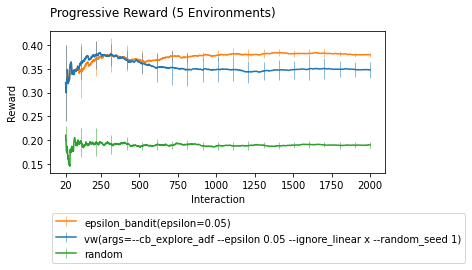

In [18]:
import coba as cb

base_environment = cb.Environments.from_linear_synthetic(2000, n_context_features=0, n_action_features=0)

environments = base_environment.noise(reward=lambda rwd,rng:rwd+rng.gauss(0,.5)).shuffle([1,2,3,4,5]).binary()
learners     = [cb.VowpalEpsilonLearner(features=[1,'a']), cb.EpsilonBanditLearner(), cb.RandomLearner() ]

result = cb.Experiment(environments, learners).run()
result.plot_learners(err='se',xlim=(20,2000))

Wow, there was a lot more output that time. We'll come back to that in a second but first, look at that plot. Our underdog, **EpsilonBanditLearner** is finally hanging with the big boys. With context_features and action_features turned off we're now evaluating against a multi-armed bandit simulation. This is actually what bandit algorithms are designed for and sure enough we can see **EpsilonBanditLearner** performs well in this simulation. 

What are those new lines, though, on the plot? Those weren't there before. Those are there because we specified `shuffle`. In fact, the reason there was so much more output with this experiment is because of `shuffle`. Applying shuffle to **Environments**  makes `n` environments (where `n` is the length of the `shuffle` list). This means there is also `n` times more output to log as we process each environment.

In [19]:
environments

1. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'shuffle': 1},{'binary': True}
2. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'shuffle': 2},{'binary': True}
3. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'shuffle': 3},{'binary': True}
4. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'shuffle': 4},{'binary': True}
5. LinearSynth(A=5,c=0,a=0,R=['a', 'xa'],seed=1),{'reward_noise': True, 'noise_seed': 1},{'shuffle': 5},{'binary': True}


## Conclusion
We hope this brief introduction has gotten you excited about the possibilities of COBA. What would you like to do first with Coba? Do you have an algorithm that you're hoping to publish and would like to easily test against other learners? Do you have a data set that you'd like to build a simulation from to see which contextual bandit algorithm performs best on it? Or are you just trying to learn more about machine learning and are just looking for an easy way to test introductory algorithms while you learn? All the above are easy to do with Coba. 

We also welcome code contributions for new features. Feel free to reach out to mr2an@virginia.edu for ideas about features that Coba could benefit from. Coba is able to do a lot more than what we've shown here. It has its own environment syntax to allow you to define environments in a separate file for easy sharing. It is also able to import environments from a number of data formats. It is able to manage resource constraints to maximize through put of long running environments. And it can download remote data sets. All of this functionality has grown out of our own experimental needs and so we hope most of what we've built will be useful to others.